In [53]:
%matplotlib inline
import torch                      # for PyTorch as a whole
import torch.nn as nn             # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F   # for activation functions
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [60]:
class Net(nn.Module):           # all models inherit from nn.Module

  def __init__(self):             # all preprocessed data and constructed layers are loaded here in __init__
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]           # all dimensions except batch dimensions
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


In [67]:
net = Net()
print(net)

input = torch.rand(1, 3, 32, 32)  # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)
print('\nRaw output:')
print(output)
print(output.shape) # first dimension is batches

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 3, 32, 32])

Raw output:
tensor([[ 0.0446,  0.0226, -0.0521,  0.0304,  0.0181, -0.1099,  0.0552, -0.0143,
          0.0374, -0.0088]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [63]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transforms.ToTensor converts images loaded by Pillow into PyTorch tensors
# transforms.Normalize adjusts the values of the nesor so the average is 0 and the standard deviation is 0.5 (normal distribution). Learning can be speeded since centering around zero is where activation functions have their strongest gradient


In [64]:
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download=True, transform = transform)
# subclass of torch-utils.data.Dataset  where data is sent, used for training?, download data?, transformations uzed
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers=2) # 2 workers to load from disk

In [65]:
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = False, num_workers=2) # 2 workers to load from disk

horse plane  frog plane


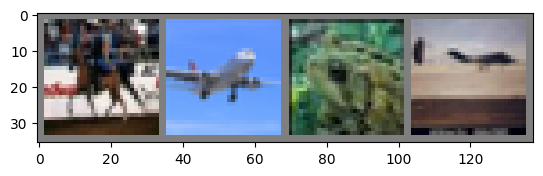

In [66]:
# Example on how to load and visualize data
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
  img = img/2 + 0.5 # unnormalize where std is 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

# gets random images from trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [70]:
criterion = nn.CrossEntropyLoss() # typical loss function for image classification models
# loss functions are a measure for how far from ideal the prediction was
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
# stochastic gradient descent, learning rate (lr), momentum

In [71]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get inputs
    inputs, labels = data

    #zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:   # print every 2000 mini-batches
      print('[%d, %5s] loss: %.3f' % (epoch + 1, i + 1, running_loss/2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.216
[1,  4000] loss: 1.885
[1,  6000] loss: 1.662
[1,  8000] loss: 1.577
[1, 10000] loss: 1.535
[1, 12000] loss: 1.472
[2,  2000] loss: 1.428
[2,  4000] loss: 1.365
[2,  6000] loss: 1.352
[2,  8000] loss: 1.352
[2, 10000] loss: 1.324
[2, 12000] loss: 1.290
Finished Training


Zeroing the gradient (line 9) is important because gradients are accumulated over a batch.

optimizer.step() moves 1 step towards a lower loss (Stochastic Gradient Descent)

In [74]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(100 * correct / total)

56.416
